#### MP2 Solution - Part 1 RL in Inventory Management

In [1]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt
from Inventory_env_class import InventoryManagementEnv, NormalizeObservation, ReplayBuffer, DQN

In [2]:
# Hyperparameters 
num_episodes = 3000
batch_size = 64
gamma = 0.75
learning_rate = 1e-3
buffer_capacity = 100000
target_update_freq = 30  # update target network every 30 episodes
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 100000  # slower decay to encourage exploration
frame_idx = 0

In [3]:
# epsilon decay function
# def get_epsilon(frame_idx):
#     return epsilon_final + (epsilon_start - epsilon_final) * np.exp(-1.0 * frame_idx / epsilon_decay)
def get_epsilon(frame_idx):
    epsilon_start = 1.0
    epsilon_end = 0.05
    epsilon_decay = 100_000  # much slower
    return epsilon_end + (epsilon_start - epsilon_end) * np.exp(-1. * frame_idx / epsilon_decay)


In [4]:
# Create environment and wrap with normalization.
env = InventoryManagementEnv()
env = NormalizeObservation(env)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = env.observation_space.shape[0]  # should be 6
output_dim = env.action_space.n             # should be 3

policy_net = DQN(input_dim, output_dim).to(device)
target_net = DQN(input_dim, output_dim).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
replay_buffer = ReplayBuffer(buffer_capacity)

all_rewards = []
losses = []       # to record loss per update
q_values_log = [] # record average Q-values per update - when Q-values from the model and avg. Q-net losses stabilize, hints at convergence

In [5]:
# Training Setup and Loop

for episode in range(num_episodes):
    obs, _ = env.reset()
    state = obs
    episode_reward = 0
    done = False
    truncated = False

    while not (done or truncated):
        frame_idx += 1
        epsilon = get_epsilon(frame_idx)
        # Epsilon-greedy action selection
        if random.random() < epsilon:
            action = env.action_space.sample()
        else:
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            with torch.no_grad():
                q_vals = policy_net(state_tensor)
            action = q_vals.max(1)[1].item()
        
        next_obs, reward, done, truncated, _ = env.step(action)
        next_state = next_obs
        replay_buffer.push(state, action, reward, next_state, done or truncated)
        state = next_state
        episode_reward += reward

        # Update the network if enough samples are available
        if len(replay_buffer) > batch_size:
            states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
            states = torch.FloatTensor(states).to(device)
            actions = torch.LongTensor(actions).unsqueeze(1).to(device)
            rewards = torch.FloatTensor(rewards).unsqueeze(1).to(device)
            next_states = torch.FloatTensor(next_states).to(device)
            dones = torch.FloatTensor(dones).unsqueeze(1).to(device)

            # Current Q values from policy network
            q_values = policy_net(states).gather(1, actions)
            
            # Next state Q values from target network
            with torch.no_grad():
                next_q_values = target_net(next_states).max(1)[0].unsqueeze(1)
            expected_q_values = rewards + gamma * next_q_values * (1 - dones)

            loss = nn.MSELoss()(q_values, expected_q_values)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            losses.append(loss.item())
            q_values_log.append(q_values.mean().item())

    all_rewards.append(episode_reward)
    
    # Update target network weights 
    if episode % target_update_freq == 0:
        target_net.load_state_dict(policy_net.state_dict())
        
    # Print progress every 50 episodes. 
    # What metrics you look at is up to you and I chose rewards, how the Q-net is training and if the Q-Values are stailizing around a value.
    # For convenience I am checking the average of last 50 values in the lists
    if episode % 50 == 0:
        avg_loss = np.mean(losses[-50:]) if losses else 0  
        avg_q = np.mean(q_values_log[-50:]) if q_values_log else 0
        print(f"Episode {episode}, Reward: {episode_reward:.2f}, Epsilon: {epsilon:.2f}, Avg Loss: {avg_loss:.4f}, Avg Q: {avg_q:.4f}")

print("Training completed!")


Episode 0, Reward: -22065.14, Epsilon: 1.00, Avg Loss: 343.6260, Avg Q: -44.4003
Episode 50, Reward: -22206.62, Epsilon: 0.79, Avg Loss: 240.2832, Avg Q: -88.1077
Episode 100, Reward: -22065.89, Epsilon: 0.62, Avg Loss: 247.0791, Avg Q: -116.8933
Episode 150, Reward: -21473.32, Epsilon: 0.50, Avg Loss: 242.0158, Avg Q: -127.2916
Episode 200, Reward: -20149.82, Epsilon: 0.40, Avg Loss: 259.4065, Avg Q: -140.3166
Episode 250, Reward: -19979.73, Epsilon: 0.32, Avg Loss: 258.7100, Avg Q: -149.2239
Episode 300, Reward: -20606.19, Epsilon: 0.26, Avg Loss: 274.8044, Avg Q: -149.1245
Episode 350, Reward: -19629.73, Epsilon: 0.21, Avg Loss: 271.7963, Avg Q: -151.3426
Episode 400, Reward: -19883.20, Epsilon: 0.18, Avg Loss: 247.8499, Avg Q: -153.5486
Episode 450, Reward: -19132.54, Epsilon: 0.15, Avg Loss: 269.1836, Avg Q: -153.4209
Episode 500, Reward: -19253.08, Epsilon: 0.13, Avg Loss: 272.0498, Avg Q: -153.7644
Episode 550, Reward: -19980.70, Epsilon: 0.11, Avg Loss: 244.3139, Avg Q: -154.02

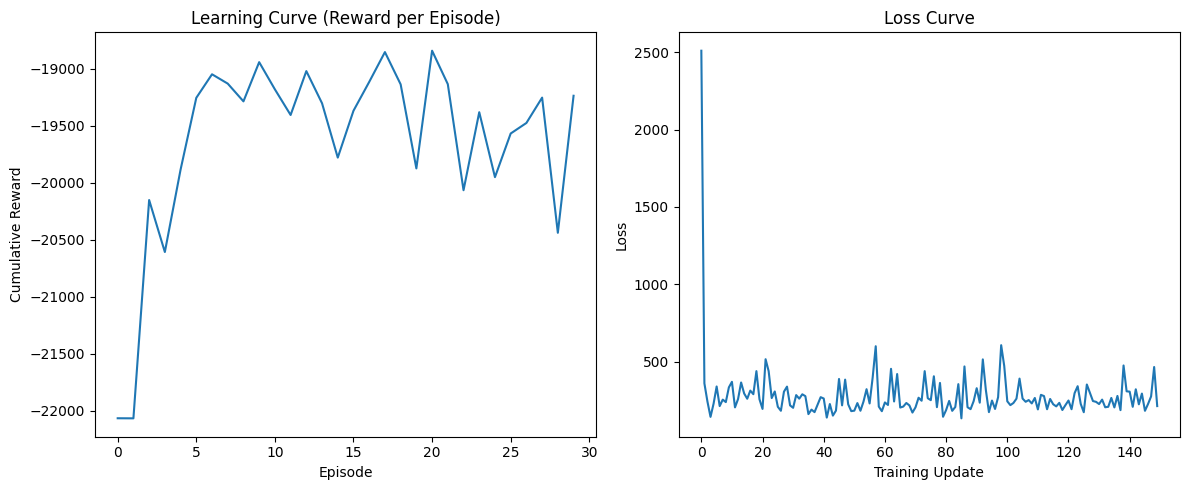

In [6]:
# Plotting Training Metrics

indices_rewards = range(0, len(all_rewards), 100)  # Get indices for every 100th element to make plot readable
values_to_plot_rewards = [all_rewards[i] for i in indices_rewards]  # Extract values at those indices

indices_losses = range(0, len(losses), 10000)  # Get indices for every 100th element
values_to_plot_losses = [losses[i] for i in indices_losses]  # Extract values at those indices

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
# plt.plot(all_rewards)
plt.plot(values_to_plot_rewards)
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.title("Learning Curve (Reward per Episode)")

plt.subplot(1,2,2)
# plt.plot(losses)
plt.plot(values_to_plot_losses)
plt.xlabel("Training Update")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.tight_layout()
plt.show()



In [7]:
# Policy Demonstration

obs, _ = env.reset()
state = obs
print("\nPolicy demonstration:")
for episode in range(30):
    state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
    with torch.no_grad():
        q_vals = policy_net(state_tensor)
    action = q_vals.max(1)[1].item()
    print(f"\nEpisode {episode+1} | Action taken: {action}")
    next_obs, reward, terminated, truncated, info = env.step(action)
    env.render()
    if terminated or truncated:
        break
    state = next_obs



Policy demonstration:

Episode 1 | Action taken: 1
Step: 1
Raw Inventory: 1.0
Product Inventory Before Sale: 0.0, After Sale: 0.0
Raw Price: 4.63, Product Price: 19.25
Demand: 11.91, Cash: 995.15

Episode 2 | Action taken: 1
Step: 2
Raw Inventory: 2.0
Product Inventory Before Sale: 0.0, After Sale: 0.0
Raw Price: 4.61, Product Price: 19.24
Demand: 10.15, Cash: 990.52

Episode 3 | Action taken: 2
Step: 3
Raw Inventory: 0.0
Product Inventory Before Sale: 1.0, After Sale: 0.0
Raw Price: 4.34, Product Price: 19.15
Demand: 5.98, Cash: 1009.77

Episode 4 | Action taken: 1
Step: 4
Raw Inventory: 1.0
Product Inventory Before Sale: 0.0, After Sale: 0.0
Raw Price: 4.45, Product Price: 18.75
Demand: 9.58, Cash: 1005.43

Episode 5 | Action taken: 1
Step: 5
Raw Inventory: 2.0
Product Inventory Before Sale: 0.0, After Sale: 0.0
Raw Price: 4.25, Product Price: 18.60
Demand: 12.94, Cash: 1000.98

Episode 6 | Action taken: 2
Step: 6
Raw Inventory: 0.0
Product Inventory Before Sale: 1.0, After Sale: 0.

In [8]:

# Save the model's state_dict
torch.save(policy_net.state_dict(), 'inv_model_state_dict.pth')

# To save the entire model
torch.save(policy_net, 'inv_entire_model.pth')